## 摘要

- 30分後の為替の変動を予測してみる

### データセット

- [GAIN Capital](http://ratedata.gaincapital.com/)
- 通貨ペア: USD/JPY
- 期間: 2018-03-04 〜 2018-04-19

### 売買の方針

- 30分後の為替の変動を予測し，何もしない, 買い， 売りを決定する．
- 30秒単位で売り買いの判断を行う．
- 0.3銭(0.0015%の手数料)を取られる
- 3銭(0.015%)以上変動しそうなら売り買いする．
- 自信がある場合のみ売り買いする．(そうでない場合は何もしない)

| 行動        | 値 | 説明                                      |
| ------------ | --- | ------------------------------------------- |
| 買い        | 1  |  現在の買値(Ask) < 将来の売値(Bid) |
| 空売り      | 2 |  現在の売値(Bid) > 将来の買値(Ask) |
| 何もしない | 0  |  それ以外 |    

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from keras.models import Input, Model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

ACTION_DO_NOTHING = 0
ACTION_LONG = 1 # 買い
ACTION_SHORT = 2 # 空売り

### LSTM Parameters
SEQ_LENGTH = 10

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.concat([pd.read_csv(fpath, parse_dates=["RateDateTime"]) for fpath in sorted(glob.glob("*.csv"))])

In [3]:
df = df.sort_values(by="RateDateTime").reset_index(drop=True)

In [4]:
df.head()

,lTid,cDealable,CurrencyPair,RateDateTime,RateBid,RateAsk
0,6474889452,D,USD/JPY,2018-03-04 17:00:09.560,105.419,105.489
1,6474889479,D,USD/JPY,2018-03-04 17:00:17.810,105.462,105.532
2,6474889521,D,USD/JPY,2018-03-04 17:00:26.060,105.458,105.528
3,6474889554,D,USD/JPY,2018-03-04 17:00:35.310,105.476,105.546
4,6474889598,D,USD/JPY,2018-03-04 17:00:38.310,105.461,105.531


In [5]:
df = df.set_index("RateDateTime", drop=True).resample("30S").mean().reset_index()

In [6]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667


In [7]:
df.describe()

,lTid,RateBid,RateAsk
count,9.877300e+04,98773.000000,98773.000000
mean,6.532411e+09,106.455745,106.461792
std,3.202130e+07,0.682563,0.682517
min,6.474889e+09,104.640000,104.657500
25%,6.504177e+09,106.007214,106.012886
50%,6.534282e+09,106.455700,106.462870
75%,6.560417e+09,107.035909,107.041280
max,6.585344e+09,107.849065,107.854043


In [8]:
T = 60 # 30分後
# T = 30 # 15分後
margin = 0.03 # 3銭の変動
df["TargetRateBid"] = df["RateBid"].shift(-T)
df["TargetRateAsk"] = df["RateAsk"].shift(-T)
df["TargetRateDateTime"] = df["RateDateTime"].shift(-T)
df["Target"] = ACTION_DO_NOTHING # 何もしない
df.loc[(df["TargetRateBid"] > df["RateAsk"] + margin), "Target"] = ACTION_LONG # 買いのタイミング
df.loc[(df["TargetRateAsk"] + margin < df["RateBid"]), "Target"] = ACTION_SHORT # 売りのタイミング

In [9]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333,105.556923,105.605846,2018-03-04 17:30:00,1
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500,105.556864,105.602682,2018-03-04 17:30:30,0
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000,105.574750,105.609650,2018-03-04 17:31:00,0
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500,105.564622,105.605333,2018-03-04 17:31:30,0
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667,105.561203,105.604331,2018-03-04 17:32:00,0


In [10]:
df["Dow"] = df["RateDateTime"].dt.dayofweek
df["Month"] = df["RateDateTime"].dt.month
df["Day"] = df["RateDateTime"].dt.day
df["Hour"] = df["RateDateTime"].dt.hour
df["Minute"] = df["RateDateTime"].dt.minute
df["RateAsk-RateBid"] = df["RateAsk"] - df["RateBid"]
# 直近との差
df["RateBidDiff_30m"] = df["RateBid"] - df["RateBid"].shift(T)
df["RateBidDiff_10m"] = df["RateBid"] - df["RateBid"].shift(T/3)
# 移動平均
df["RateBidAvg_30m"] = df["RateBid"].rolling(window=T).mean()
df["RateBidAvg_10m"] = df["RateBid"].rolling(window=T/3).mean()
df["RateBidAvg_30m/RateBid"] = df["RateBidAvg_30m"] / df["RateBid"]
df["RateBidAvg_10m/RateBid"] = df["RateBidAvg_10m"] / df["RateBid"]
# 分散
df["RateBidStd_30m"] = df["RateBid"].rolling(window=T).std()
df["RateBidStd_10m"] = df["RateBid"].rolling(window=T/3).std()
# ポリジャーバンド
df["RateBidUpper_10m"] = df["RateBidAvg_10m"] + 2.0 * df["RateBidStd_10m"]
df["RateBidLower_10m"] = df["RateBidAvg_10m"] - 2.0 * df["RateBidStd_10m"]
df["RateBidUpper_10m/RateBid"] = df["RateBidUpper_10m"] / df["RateBid"]
df["RateBidLower_10m/RateBid"] = df["RateBidLower_10m"] / df["RateBid"]
# t値
df["RateBid_t_30m"] = (df["RateBid"] - df["RateBidAvg_30m"]) / df["RateBidStd_30m"]
df["RateBid_t_10m"] = (df["RateBid"] - df["RateBidAvg_10m"]) / df["RateBidStd_10m"]

# フィボナッチすごい, cf. https://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9
nums = [2, 3, 5, 8, 13, 21, 34, 55]
cols = []
for num in nums:
    interval = num
    col = "RateBidMedian_%05d" % interval
    cols.append(col)
    df[col] = df["RateBid"].rolling(window=interval).median()
df["RateBidMedian"] = df[cols].median(axis=1)
df["RateBidMedian/RateBid"] = df["RateBidMedian"] / df["RateBid"] 

In [11]:
df.dropna(inplace=True)

In [12]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target,Dow,Month,...,RateBidMedian_00002,RateBidMedian_00003,RateBidMedian_00005,RateBidMedian_00008,RateBidMedian_00013,RateBidMedian_00021,RateBidMedian_00034,RateBidMedian_00055,RateBidMedian,RateBidMedian/RateBid
60,2018-03-04 17:30:00,6.474910e+09,105.556923,105.605846,105.625458,105.644208,2018-03-04 18:00:00,0,6,3,...,105.560087,105.563250,105.578857,105.577704,105.579750,105.57655,105.578218,105.572217,105.577127,1.000191
61,2018-03-04 17:30:30,6.474911e+09,105.556864,105.602682,105.627177,105.639097,2018-03-04 18:00:30,0,6,3,...,105.556893,105.556923,105.563250,105.577704,105.579750,105.57600,105.577064,105.572217,105.574109,1.000163
62,2018-03-04 17:31:00,6.474911e+09,105.574750,105.609650,105.611046,105.621966,2018-03-04 18:01:00,0,6,3,...,105.565807,105.556923,105.563250,105.575650,105.578857,105.57600,105.577064,105.574750,105.575200,1.000004
63,2018-03-04 17:31:30,6.474912e+09,105.564622,105.605333,105.613574,105.620553,2018-03-04 18:01:30,0,6,3,...,105.569686,105.564622,105.563250,105.569686,105.576550,105.57600,105.576275,105.574750,105.572218,1.000072
64,2018-03-04 17:32:00,6.474912e+09,105.561203,105.604331,105.641737,105.652526,2018-03-04 18:02:00,1,6,3,...,105.562913,105.564622,105.561203,105.563936,105.576000,105.57600,105.575375,105.574750,105.569686,1.000080


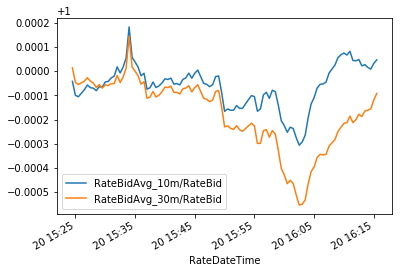

In [13]:
df[-100:].set_index("RateDateTime")[["RateBidAvg_10m/RateBid", "RateBidAvg_30m/RateBid"]].plot();

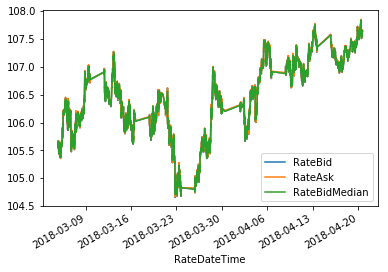

In [14]:
df.set_index("RateDateTime")[["RateBid", "RateAsk", "RateBidMedian"]].plot();

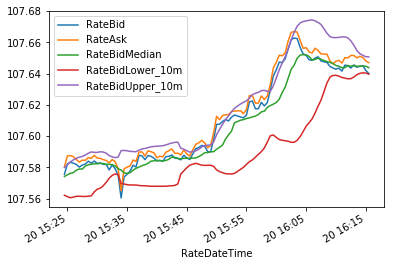

In [15]:
df[-100:].set_index("RateDateTime")[["RateBid", "RateAsk", "RateBidMedian", "RateBidLower_10m", "RateBidUpper_10m"]].plot();

In [16]:
use_columns = [
    "RateAsk-RateBid", 
    "Dow", 
    # "Month",
    # "Day", 
    "Hour", 
    # "Minute", 
    "RateBidDiff_30m", "RateBidDiff_10m", 
    "RateBidAvg_30m/RateBid", "RateBidAvg_10m/RateBid",
    "RateBidStd_30m", "RateBidStd_10m",
    "RateBidUpper_10m/RateBid", "RateBidLower_10m/RateBid",
    "RateBid_t_30m", "RateBid_t_10m",
    "RateBidMedian/RateBid"
]

In [17]:
def transform(df, seq_length):
    num_train = int(len(df) * 0.8)
    x_all = df[use_columns].values
    y_all = df["Target"].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    m = seq_length
    n = len(use_columns)
    for i in range(m, len(df)):
        if i < num_train:
            X_train.append(x_all[-m+i:i].copy())
            y_train.append(y_all[i].copy())
        else:
            X_test.append(x_all[-m+i:i].copy())
            y_test.append(y_all[i].copy())
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    return (X_train,  y_train), (X_test, y_test)

In [18]:
def build(seq_length, max_features):
    input_tensor = Input(shape=(seq_length, max_features))
    x = LSTM(128)(input_tensor)
    x = Dropout(0.5)(x)
    prediction = Dense(3, activation="softmax")(x)
    model = Model(input_tensor, prediction)
    return model

In [19]:
# 特徴抽出
(X_train, y_train), (X_test, y_test) = transform(df, seq_length=SEQ_LENGTH)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [20]:
# モデル構築
model = build(seq_length=SEQ_LENGTH, max_features=len(use_columns))
model.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
)
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 14)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               73216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 73,603
Trainable params: 73,603
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# 学習
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=True, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True, epsilon=1e-4),
]
num_valid = int(len(X_train) * 0.2)
history = model.fit(X_train[:-num_valid], Y_train[:-num_valid], 
          validation_data=(X_train[-num_valid:], Y_train[-num_valid:]),
          callbacks=callbacks,
          batch_size=1024, 
          epochs=200)

Train on 45577 samples, validate on 11394 samples
Epoch 1/200
45577/45577 [==============================] - 2s 42us/step - loss: 1.1160 - acc: 0.3701 - val_loss: 1.0926 - val_acc: 0.3546
Epoch 2/200
45577/45577 [==============================] - 0s 11us/step - loss: 1.0878 - acc: 0.3859 - val_loss: 1.0863 - val_acc: 0.4173
Epoch 3/200
45577/45577 [==============================] - 0s 10us/step - loss: 1.0817 - acc: 0.3962 - val_loss: 1.0867 - val_acc: 0.3900
Epoch 4/200
45577/45577 [==============================] - 0s 10us/step - loss: 1.0773 - acc: 0.4025 - val_loss: 1.0822 - val_acc: 0.4200
Epoch 5/200
45577/45577 [==============================] - 0s 10us/step - loss: 1.0730 - acc: 0.4046 - val_loss: 1.0786 - val_acc: 0.4153
Epoch 6/200
45577/45577 [==============================] - 0s 10us/step - loss: 1.0646 - acc: 0.4117 - val_loss: 1.1033 - val_acc: 0.3916
Epoch 7/200
45577/45577 [==============================] - 0s 10us/step - loss: 1.0566 - acc: 0.4214 - val_loss: 1.1138 - 

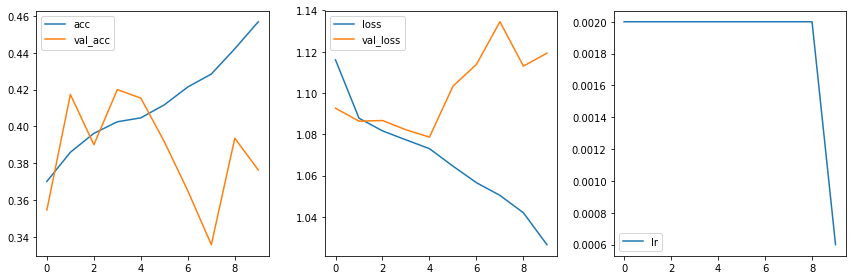

In [22]:
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
history_df[["acc", "val_acc"]].plot(ax=axes[0])
history_df[["loss", "val_loss"]].plot(ax=axes[1])
history_df[["lr"]].plot(ax=axes[2])
fig.tight_layout()

- 全然val_lossが減ってないし，学習できていなさそう．
- データ数を増やせばなんとかなる？

In [23]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

In [24]:
num_train = int(len(df) * 0.8)
train_df = df[:num_train]
test_df = df[num_train:]

In [25]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(56971, 10, 14) (56971,) (14246, 10, 14) (14246,)


In [26]:
print "Accuracy: %.4f" % accuracy_score(y_test, y_pred)
print "Recall:       %.4f" % recall_score(y_test, y_pred, average="macro")
print "Precision:  %.4f" % precision_score(y_test, y_pred, average="macro")
print "F1:             %.4f" % f1_score(y_test, y_pred, average="macro")

Accuracy: 0.3593
Recall:       0.3231
Precision:  0.3256
F1:             0.3112


## 収益計算

In [27]:
def calc_gain(x, charge=0.003):
    if x["pred"] == ACTION_DO_NOTHING:
        return 0
    if x["pred"] == ACTION_LONG: # 買って売る
        return x["TargetRateBid"] - x["RateAsk"] - 2*charge
    if x["pred"] == ACTION_SHORT: # 売って買う
        return x["RateBid"] - x["TargetRateAsk"] - 2*charge
test_df["pred"] = y_pred
test_df["gain"] = test_df.apply(calc_gain, axis=1)

In [28]:
print "収益の期待値(1ドルあたり): %.4f円" % test_df["gain"].mean()
print "収益の合算値: %.4f円" % test_df["gain"].sum()
print "買った回数: %d" % (test_df["pred"] == ACTION_LONG).sum()
print "売った回数: %d" % (test_df["pred"] == ACTION_SHORT).sum()
print "何もしなかった回数: %d" % (test_df["pred"] == ACTION_DO_NOTHING).sum()

収益の期待値(1ドルあたり): -0.0092円
収益の合算値: -130.4137円
買った回数: 5628
売った回数: 2837
何もしなかった回数: 5781


## まとめ

- LSTMで為替を予測
- XGBoost版より性能悪化．
- 特徴抽出やデータ数など，改善箇所はまだまだある．

## References

> [1]. [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting), kaggle, 2017.

> [2]. [GAIN Capital](http://ratedata.gaincapital.com/)